In [1]:
!pip install missingno

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats as st
import seaborn as sns

In [3]:
# загрузим наш датафрейм
df = pd.read_csv('games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# изучим общуую информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Из первичного анализа данных видно, что есть пропущенные данные. Основные пропуски в оценках и рейтинге. Также колонка Year_of_Release, User_Score в нестандартном формате для года и оценок. Необходимо это поправить

## Подготовка данных

In [5]:
# приведем название столбцов к нижнему регистру

df.columns = map(str.lower, df.columns)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


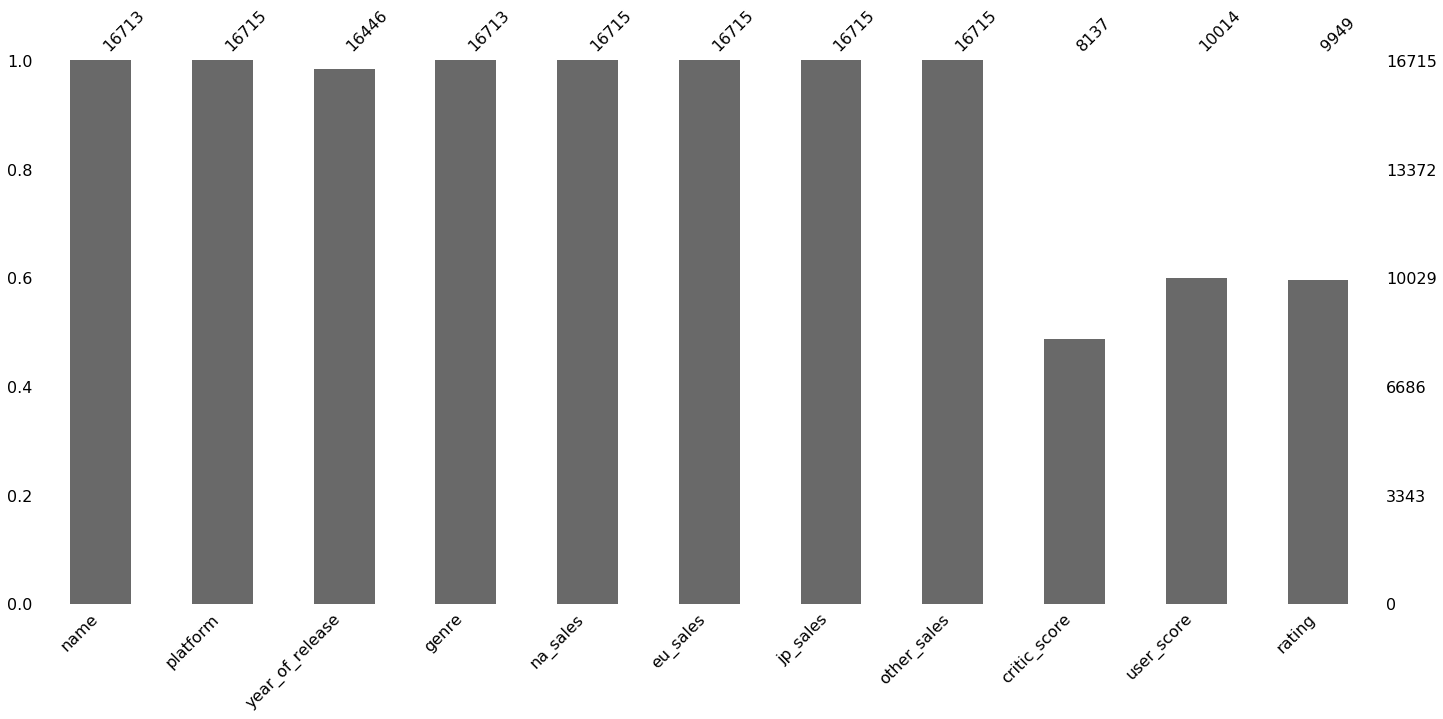

In [6]:
# произведём небольшой разведочный анализ данных
# посмотрим по какому столбцу большего всего пропущенных значений
msno.bar(df)

Анализ показал, что у нас нет информации по столбцам "critic_score", "user_score","rating"

Причинами пропусков могут быть ошибки ввода данных, сокрытие информации, фрод. 
<p>Похоже, что в нашем случае, причина пропусков связана с тем, что до 94-ого года не было рейтинга ESRB (SRB была основана в 1994 году <a href="https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board" title="Entertainment_Software_Rating_Board_wikipedia"> ESRB_wikipedia </a> ), а также возможно данные просто ошибочно не были введены </p>

In [7]:
# заменим все NaN-данные нулем, чтобы было удобнее считать и преобразовывать данные

df = df.fillna(0)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,0.0,0,0
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,0


In [8]:
# заменим тип данных в столбце year_of_release, так как год у нас целое число

df['year_of_release'] = df['year_of_release'].astype(int)

df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0,0
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,0


In [9]:
# cгруппируем данные в столбцах с рейтингом, чтобы  найти аббревиатуру 'tbd'
df.groupby(['user_score', 'critic_score'])['genre'].count()

user_score  critic_score
0           0.0             6663
            33.0               1
            40.0               1
            44.0               1
            46.0               1
                            ... 
tbd         86.0               2
            87.0               1
            88.0               1
            89.0               1
            90.0               1
Name: genre, Length: 2499, dtype: int64

аббревиатура 'tbd'расшифровывается - To Be Determined, то есть "Будет определено". Когда данные готовятся, но пока ещё нет возможности назвать точную оценку, именно это сокращение и используется.

In [10]:
# заменим "tbd" на ноль для того, чтобы было удобно считать

df['user_score']= df['user_score'].replace('tbd', 0.00)
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0,0
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0,0


In [11]:
# поменяем тип данных user_score на float, чтобы было удобно считать 

df['user_score'] = df['user_score'].astype(float)
df.dtypes

name                object
platform            object
year_of_release      int32
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float64
rating              object
dtype: object

In [12]:
# посчитаем суммарные продажи во всех регионах и запишите их в отдельный столбец

df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,0,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,0,31.38


## Исследовательский анализ данных

In [13]:
# посмотрим, сколько игр выпускалось в разные годы
df.groupby('year_of_release')['name'].count()

year_of_release
0        269
1980       9
1981      46
1982      36
1983      17
1984      14
1985      14
1986      21
1987      16
1988      15
1989      17
1990      16
1991      41
1992      43
1993      62
1994     121
1995     219
1996     263
1997     289
1998     379
1999     338
2000     350
2001     482
2002     829
2003     775
2004     762
2005     939
2006    1006
2007    1197
2008    1427
2009    1426
2010    1255
2011    1136
2012     653
2013     544
2014     581
2015     606
2016     502
Name: name, dtype: int64

In [14]:
# посмотрим, сколько всего игр выпускалось за все годы
df['name'].count()

16715

Так как до 94-ого года у нас есть не все данные, а количество игр до этого периода выпускалось не так много, думаю,
что данные до 94 года можно удалить

In [15]:
# удалим данные до 1994 года
df = df.loc[df['year_of_release'] >= 1994]

In [16]:
# посмотрим, как менялись продажи по платформам, создадим сводную таблицу и отсортируем по убыванию

df_pivot = df.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']
                          , aggfunc='sum').sort_values(by = 'total_sales', ascending=False)
df_pivot

,eu_sales,jp_sales,na_sales,other_sales,total_sales
platform,,,,,
PS2,332.63,137.54,572.92,190.47,1233.56
X360,268.32,12.30,595.74,84.88,961.24
PS3,327.21,79.41,390.13,134.59,931.34
Wii,258.32,68.28,486.87,77.71,891.18
DS,188.41,175.00,380.31,59.04,802.76
PS,212.39,139.78,334.72,40.69,727.58
PS4,141.09,15.96,108.74,48.35,314.14
GBA,74.59,46.56,184.12,7.61,312.88
PSP,65.62,75.88,107.27,40.76,289.53


In [17]:
# отберем 5 платформ с наибольшими суммарными продажами
df_pivot.sort_values(by = 'total_sales', ascending=False).head(5)

,eu_sales,jp_sales,na_sales,other_sales,total_sales
platform,,,,,
PS2,332.63,137.54,572.92,190.47,1233.56
X360,268.32,12.30,595.74,84.88,961.24
PS3,327.21,79.41,390.13,134.59,931.34
Wii,258.32,68.28,486.87,77.71,891.18
DS,188.41,175.00,380.31,59.04,802.76


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

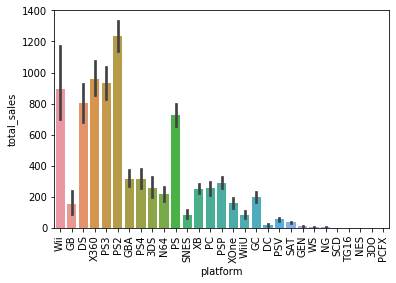

In [18]:
# построим график для наглядности

sns.barplot(data=df, x='platform', y='total_sales', estimator=np.sum)
plt.xticks(rotation=90)

Получается, что большего всего было продано на платформах PS2, X360, PS3, Wii,DS	

In [64]:
df_pivot.index

Index(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS',
       'PC', 'XB', 'N64', 'GC', 'XOne', 'GB', 'SNES', 'WiiU', 'PSV', 'SAT',
       'DC', 'GEN', 'WS', 'NG', 'SCD', 'TG16', 'NES', '3DO', 'PCFX'],
      dtype='object', name='platform')

In [65]:
df_pivot.reset_index()['platform']

0      PS2
1     X360
2      PS3
3      Wii
4       DS
5       PS
6      PS4
7      GBA
8      PSP
9      3DS
10      PC
11      XB
12     N64
13      GC
14    XOne
15      GB
16    SNES
17    WiiU
18     PSV
19     SAT
20      DC
21     GEN
22      WS
23      NG
24     SCD
25    TG16
26     NES
27     3DO
28    PCFX
Name: platform, dtype: object

In [66]:
# platform не отражается как столбец

df_pivot.columns

Index(['eu_sales', 'jp_sales', 'na_sales', 'other_sales', 'total_sales'], dtype='object')

In [19]:
# построим распределение по годам по платформам с наибольшими суммарными продажами

df_max =df.query('platform in ["PS2", "X360", "PS3", "Wii","DS","PS4"]') \
    .groupby(['platform','year_of_release']) \
    .agg({'total_sales': 'sum'})\

df_max

total_sales
platform year_of_release             
DS       2004                   17.27
         2005                  130.14
         2006                  119.81
         2007                  146.94
         2008                  145.31
         2009                  119.54
         2010                   85.02
         2011                   26.18
         2012                   11.01
         2013                    1.54
PS2      2000                   39.17
         2001                  166.43
         2002                  205.38
         2003                  184.31
         2004                  211.81
         2005                  160.66
         2006                  103.42
         2007                   75.99
         2008                   53.90
         2009                   26.40
         2010                    5.64
         2011                    0.45
PS3      2006                   20.96
         2007                   73.19
         2008                  118.52
         2009                  130.93
         2010                  142.17
         2011                  156.78
         2012                  107.36
         2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
Wii      2006                  137.15
         2007                  152.77
         2008                  171.32
         2009                  206.97
         2010                  127.95
         2011                   59.65
         2012                   21.71
         2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
X360     2005                    8.25
         2006                   51.62
         2007                   95.41
         2008                  135.26
         2009                  120.29
         2010                  170.03
         2011                  143.84
         2012                   99.74
         2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52

Видим тенденцию к снижению по платформам с наибольшими суммарными продажами к 2016 году. Наибольший пик продаж пришелся на первое десятилетие 2000 годов

In [20]:
# построем распределение по годам 
df_max =df.query('year_of_release >= 2000').groupby(['year_of_release', 'platform'])['total_sales'].sum()

df_max.head(60)

year_of_release  platform
2000             DC            5.99
                 GB           19.76
                 GBA           0.07
                 N64          33.97
                 PC            4.66
                 PS           96.37
                 PS2          39.17
                 WS            0.68
                 XB            0.99
2001             DC            1.07
                 GB            9.24
                 GBA          61.53
                 GC           26.34
                 N64           3.25
                 PC            5.47
                 PS           35.59
                 PS2         166.43
                 WS            0.28
                 XB           22.26
2002             DC            0.29
                 GBA          74.16
                 GC           51.81
                 N64           0.08
                 PC            8.57
                 PS            6.67
                 PS2         205.38
                 XB           48.01
20

In [21]:
df_m =df.query('year_of_release >= 2000').groupby(['year_of_release', 'platform'])['total_sales'].sum()

df_m.tail(50)

year_of_release  platform
2011             X360        143.84
2012             3DS          51.36
                 DS           11.01
                 PC           23.22
                 PS3         107.36
                 PSP           7.69
                 PSV          16.19
                 Wii          21.71
                 WiiU         17.56
                 X360         99.74
2013             3DS          56.57
                 DS            1.54
                 PC           12.38
                 PS3         113.25
                 PS4          25.99
                 PSP           3.14
                 PSV          10.59
                 Wii           8.59
                 WiiU         21.65
                 X360         88.58
                 XOne         18.96
2014             3DS          43.76
                 PC           13.28
                 PS3          47.76
                 PS4         100.00
                 PSP           0.24
                 PSV          11.90
  

Из среза видно, что N64, PC, SNES -  популярные в прошлом платформы, у которых сейчас продажи не на нуле, но упали. 
C 2001 PS2 делает значительный рывок по продажам и исчезают старые платформы. С 2007 набирает оборот по продажам PS3, а с 2014 - PS4



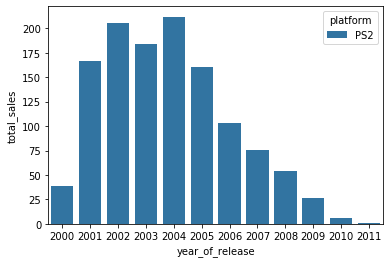

In [67]:
# построим график распределения total_sales по годам по самым продаваемым платформам PS2, X360, PS3, Wii,DS

PS2 = df.query('platform == "PS2"').groupby(['platform', 'year_of_release'], as_index = False).agg({'total_sales':'sum'})
sns.barplot(data=PS2, x='year_of_release', y='total_sales', estimator=np.sum, hue="platform")

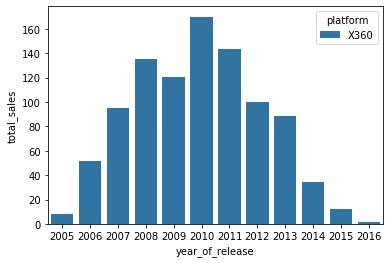

In [68]:
X360 = df.query('platform == "X360"').groupby(['platform', 'year_of_release'], as_index = False).agg({'total_sales':'sum'})
sns.barplot(data=X360, x='year_of_release', y='total_sales', estimator=np.sum, hue="platform")


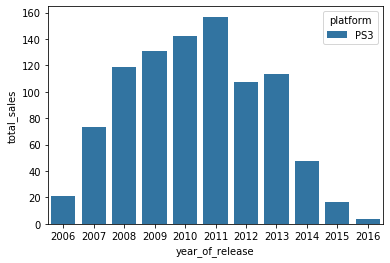

In [69]:
PS3 = df.query('platform == "PS3"').groupby(['platform', 'year_of_release'], as_index = False).agg({'total_sales':'sum'})
sns.barplot(data=PS3, x='year_of_release', y='total_sales', estimator=np.sum, hue="platform")


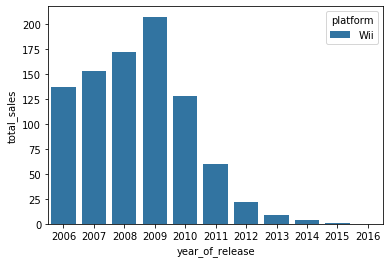

In [70]:
Wii = df.query('platform == "Wii"').groupby(['platform', 'year_of_release'], as_index = False).agg({'total_sales':'sum'})
sns.barplot(data=Wii, x='year_of_release', y='total_sales', estimator=np.sum, hue="platform")

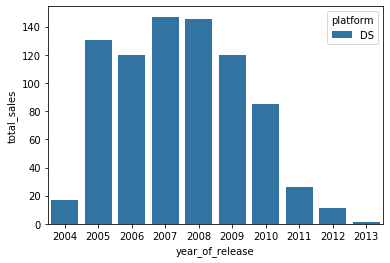

In [71]:
DS = df.query('platform == "DS"').groupby(['platform', 'year_of_release'], as_index = False).agg({'total_sales':'sum'})
sns.barplot(data=DS, x='year_of_release', y='total_sales', estimator=np.sum, hue="platform")

In [72]:
# найдем средний период жизни по самым продаваемым платформам

X360 = df[df['platform'] == "X360"].year_of_release.max() - df[df['platform'] == "X360"].year_of_release.min()
PS2 = df[df['platform'] == "PS2"].year_of_release.max() - df[df['platform'] == "PS2"].year_of_release.min()
PS3 = df[df['platform'] == "PS3"].year_of_release.max() - df[df['platform'] == "PS3"].year_of_release.min()
Wii = df[df['platform'] == "Wii"].year_of_release.max() - df[df['platform'] == "Wii"].year_of_release.min()  
DS = df[df['platform'] == "3DS"].year_of_release.max() - df[df['platform'] == "3DS"].year_of_release.min()
total = (X360+PS2+PS3+Wii+DS) / 5
total

9.4

Из среза видно, что N64, PC, SNES -  популярные в прошлом платформы, у которых сейчас продажи не на нуле, но сильно упали. А вот платформы, которые собрали больше всего продаж (наш топ-5), уже не покупаются к 2016 году.
Средняя продолжительность существования платформы составляет примерно 10 лет.
C 2001 PS2 делает значительный рывок по продажам и исчезают старые платформы. С 2007 набирает оборот по продажам PS3, а с 2014 - PS4
Проверим какие же платформы пользуются наибольшей популярностью в 2016 г.


In [73]:
df.groupby(['platform', 'year_of_release'], as_index = False).agg({'total_sales':'sum'}).sort_values('total_sales', ascending=False).head()

,platform,year_of_release,total_sales
98,PS2,2004,211.81
159,Wii,2009,206.97
96,PS2,2002,205.38
97,PS2,2003,184.31
158,Wii,2008,171.32


In [24]:
# определим какие данные за какой период нужно взять, чтобы исключить значимое искажение распределения по платформам в 2016 году

df.query('year_of_release == 2016').groupby(['year_of_release', 'platform'])['total_sales'].sum()

year_of_release  platform
2016             3DS         15.14
                 PC           5.25
                 PS3          3.60
                 PS4         69.25
                 PSV          4.25
                 Wii          0.18
                 WiiU         4.60
                 X360         1.52
                 XOne        26.15
Name: total_sales, dtype: float64

По графику и данным видны явные выбросы, считаю, что для дальнейшего анализа стоит взять последние 5 лет, чтобы исключить значимое искажение распределения по платформам в 2016 году 

In [25]:
# создадим новый датафрейм с 2012 по 2016 

df_new = df.query('year_of_release >= 2012')
df_new

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,0.0,0.0,0,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,0.0,0.0,0,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.0,0.0,0,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,0.0,0.0,0,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,0.0,0.0,0,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,0.0,0.0,0,0.01


In [26]:
# определим какие платформы лидируют по продажам, растут или падают Выберите несколько потенциально прибыльных платформ.

df_new.groupby(['year_of_release', 'platform'])['total_sales'].sum()

year_of_release  platform
2012             3DS          51.36
                 DS           11.01
                 PC           23.22
                 PS3         107.36
                 PSP           7.69
                 PSV          16.19
                 Wii          21.71
                 WiiU         17.56
                 X360         99.74
2013             3DS          56.57
                 DS            1.54
                 PC           12.38
                 PS3         113.25
                 PS4          25.99
                 PSP           3.14
                 PSV          10.59
                 Wii           8.59
                 WiiU         21.65
                 X360         88.58
                 XOne         18.96
2014             3DS          43.76
                 PC           13.28
                 PS3          47.76
                 PS4         100.00
                 PSP           0.24
                 PSV          11.90
                 Wii           3.75
  

В лидерах платформы - PS4, 3DS, XOne. С выходом новой платформы продажи по PS3 стали падать. Хуже всего продажи по PSP, DS, Wii

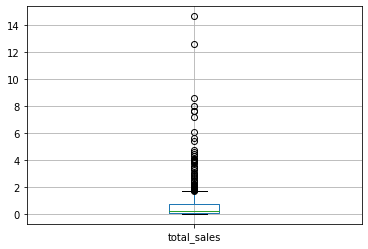

In [74]:
# построим график «ящик с усами» по глобальным продажам каждой игры и разбивкой по платформам

PS4 = df_new.query('platform == "PS4"')
PS4.boxplot(column='total_sales')


In [75]:
df_new.query('platform == "PS4"').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,2015.145408,0.277398,0.359923,0.040714,0.123342,46.344388,4.424235,0.801378
std,0.868181,0.583723,0.810843,0.069101,0.254825,36.004920,3.420952,1.609456
min,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2015.000000,0.007500,0.000000,0.000000,0.010000,0.000000,0.000000,0.060000
50%,2015.000000,0.060000,0.080000,0.010000,0.030000,64.500000,6.100000,0.200000
75%,2016.000000,0.260000,0.300000,0.050000,0.110000,77.000000,7.500000,0.730000
max,2016.000000,6.030000,6.310000,0.490000,2.380000,97.000000,9.200000,14.630000


Видно, что худшие продажи (0.01) по платформе PS4 были в 2013 году, лучший продажный год 2016 - 14.63 Медиана продаж - 0.2

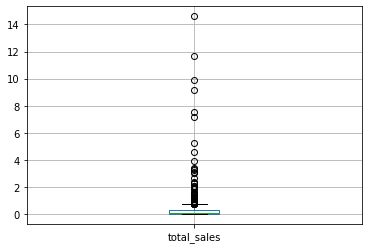

In [76]:
DS = df_new.query('platform == "3DS"')
DS.boxplot(column='total_sales')


In [77]:
df_new.query('platform == "3DS"').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000,396.000000
mean,2013.750000,0.139672,0.107677,0.221692,0.022399,18.335859,2.024747,0.491439
std,1.339044,0.491059,0.389226,0.558128,0.078660,31.370563,3.285626,1.387161
min,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2013.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.040000
50%,2014.000000,0.000000,0.000000,0.060000,0.000000,0.000000,0.000000,0.110000
75%,2015.000000,0.090000,0.050000,0.170000,0.010000,46.000000,5.250000,0.312500
max,2016.000000,5.280000,4.190000,4.390000,0.780000,92.000000,9.100000,14.600000


Видно, что худшие продажи (0.01) в 2012 по платформе 3DS, лучший продажный год 2016 - 14.60. Медиана продаж - 0.11

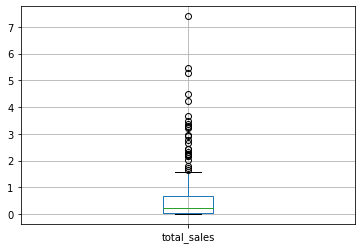

In [78]:
XOne = df_new.query('platform == "XOne"')
XOne.boxplot(column='total_sales')

In [79]:
df_new.query('platform == "XOne"').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000,247.000000
mean,2014.951417,0.377004,0.208866,0.001377,0.057773,50.170040,4.805263,0.645020
std,0.952995,0.630618,0.365306,0.005153,0.094221,35.791336,3.111794,1.036139
min,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,2014.000000,0.030000,0.020000,0.000000,0.010000,0.000000,0.000000,0.060000
50%,2015.000000,0.120000,0.070000,0.000000,0.020000,67.000000,6.000000,0.220000
75%,2016.000000,0.385000,0.220000,0.000000,0.060000,79.000000,7.200000,0.685000
max,2016.000000,4.590000,2.190000,0.040000,0.680000,97.000000,9.200000,7.390000


Видно, что худшие продажи (0.01) в 2013 по платформе XOne, лучший продажный год 2016 - 7.39. Медиана продаж - 0.22

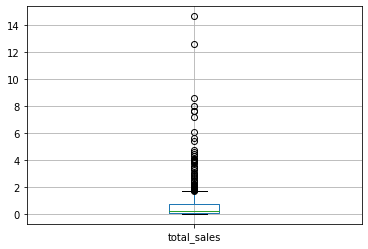

In [80]:
PS4 = df_new.query('platform == "PS4"')

PS4.boxplot(column='total_sales')

In [82]:
# посмотрим, как влияют на продажи внутри одной популярной платформы  PS4 отзывы пользователей и критиков. 
PS4 = df_new.query('platform == "PS4" and critic_score > 0 and user_score > 0')


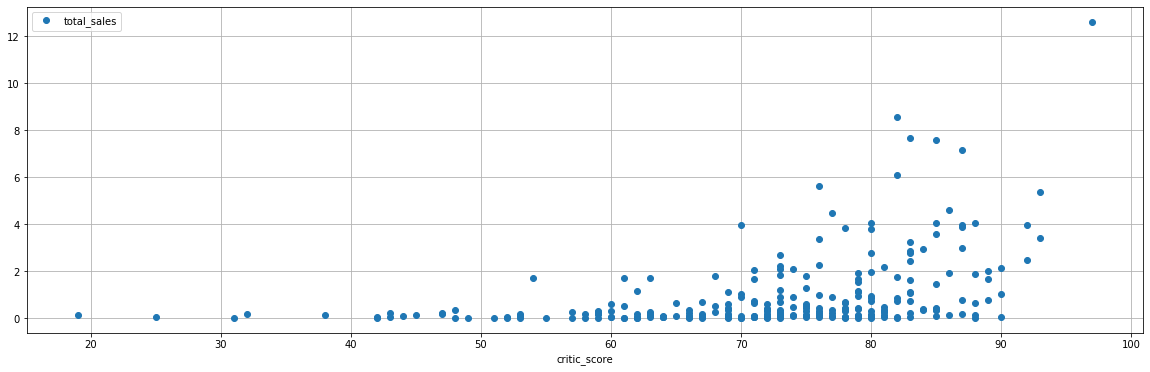

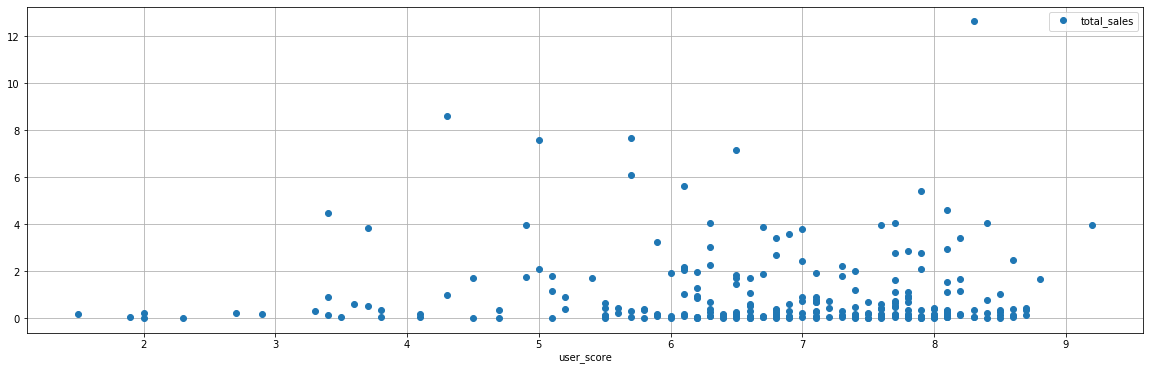

In [83]:
PS4.plot(x= 'critic_score', y= 'total_sales', style='o', grid=True, figsize=(20, 6))
PS4.plot(x= 'user_score', y= 'total_sales', style='o', grid=True, figsize=(20, 6))

In [85]:
# найдем корреляцию м/у продажами и оценкой критиков

PS4['total_sales'].corr(PS4['critic_score'])

0.40589480145836687

In [31]:
# найдем корреляцию м/у продажами и оценкой пользователей

PS4['total_sales'].corr(PS4['user_score'])

0.11311562450852884

Оценки критиков и пользователей различаются, при этом продажи имеют слабую корреляцию с оценками. Оценки пользователей даже имеют отрицательную корреляцию

-0.09400318326920852

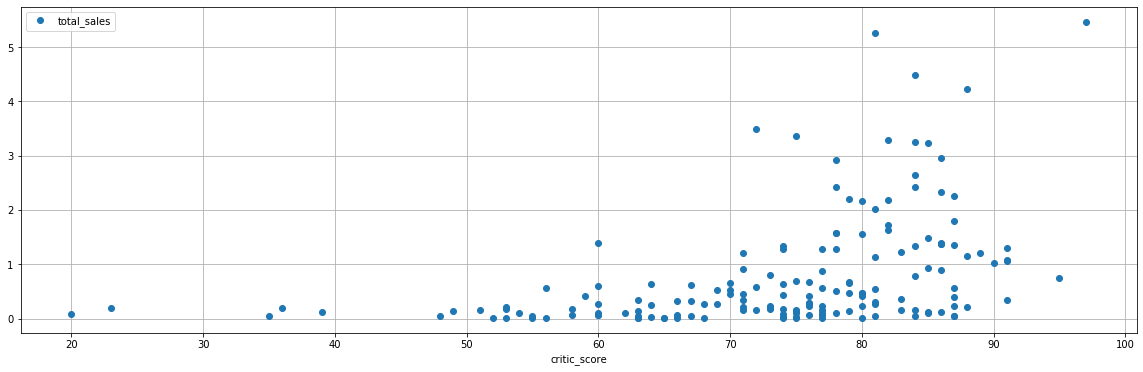

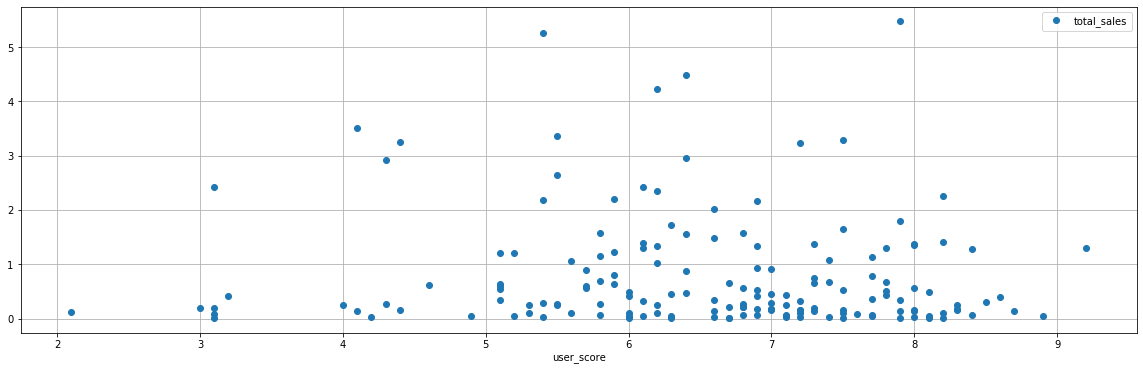

In [86]:
# посмотрим ещё платформу XOne для сравнения
XOne = df_new.query('platform == "XOne" and critic_score > 0 and user_score > 0')

XOne.plot(x= 'critic_score', y= 'total_sales', style='o', grid=True, figsize=(20, 6))
XOne.plot(x= 'user_score', y= 'total_sales', style='o', grid=True, figsize=(20, 6))
XOne['total_sales'].corr(XOne['user_score'])


In [87]:
XOne['total_sales'].corr(XOne['critic_score'])

0.4104220356129637

0.2018125500765528

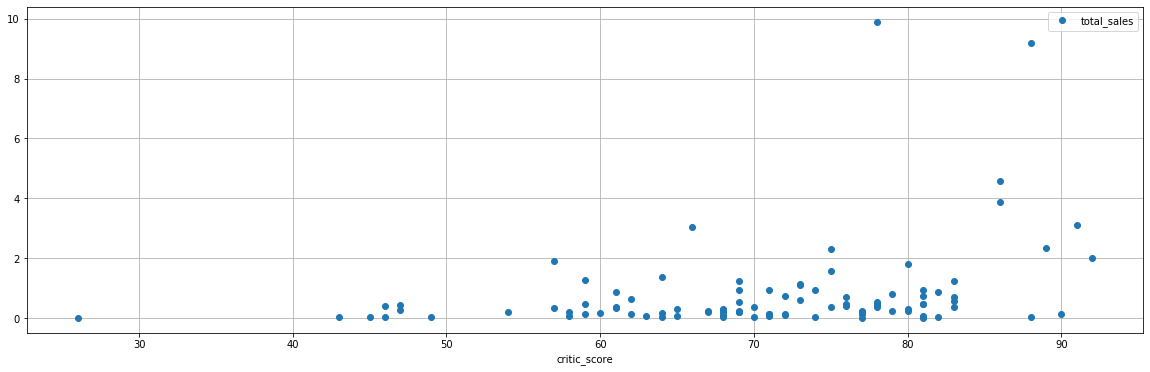

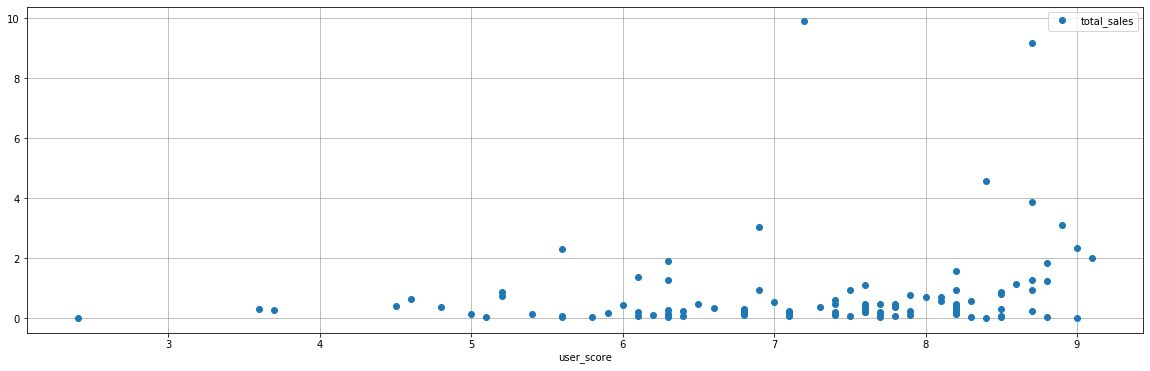

In [88]:
# посмотрим ещё платформу 3DS для сравнения
DS = df_new.query('platform == "3DS" and critic_score > 0 and user_score > 0')

DS.plot(x= 'critic_score', y= 'total_sales', style='o', grid=True, figsize=(20, 6))
DS.plot(x= 'user_score', y= 'total_sales', style='o', grid=True, figsize=(20, 6))
DS['total_sales'].corr(DS['user_score'])


In [89]:
DS['total_sales'].corr(DS['critic_score'])

0.31055301915326294

Корелляция по оценкам и продажам разная по лидерам платформ - PS4, 3DS, XOne. Единственным объединяющим факторам можно считать слабую связь между оценками критиков и особенно пользователей

In [34]:
# посмотрим на общее распределение игр по жанрам. 
df_new.groupby('genre', as_index=False).agg({'total_sales': 'sum'}).sort_values(by ='total_sales', ascending=False)

,genre,total_sales
0,Action,441.12
8,Shooter,304.73
7,Role-Playing,192.80
10,Sports,181.07
3,Misc,85.04
4,Platform,61.00
6,Racing,53.50
2,Fighting,44.49
9,Simulation,35.12
1,Adventure,29.43


Можно сказать, что самых прибыльные жанры - это Action, Shooter, Role-Playing, Sports, Misc. Есть чёткая параллель между жанрами и продажами


# Портрет пользователя каждого региона

In [35]:
# Самые популярные платформы (топ-5) для каждого региона. 

na= df_new.groupby('platform', as_index=False).agg({'na_sales': 'sum'}).sort_values(by ='na_sales', ascending=False).head()
na

,platform,na_sales
9,X360,140.05
4,PS4,108.74
3,PS3,103.38
10,XOne,93.12
0,3DS,55.31


In [36]:
# общая сумма продаж na_sales

total_na =df_new['na_sales'].sum()
total_na

590.97

In [37]:
# доля продаж (топ-5) для na_sales

ratio_na = (na['na_sales'] / total_na) 
ratio_na

9     0.236983
4     0.184003
3     0.174933
10    0.157571
0     0.093592
Name: na_sales, dtype: float64

In [38]:
eu = df_new.groupby('platform', as_index=False).agg({'eu_sales': 'sum'}).sort_values(by ='eu_sales', ascending=False).head()
eu

,platform,eu_sales
4,PS4,141.09
3,PS3,106.86
9,X360,74.52
10,XOne,51.59
0,3DS,42.64


In [39]:
# общая сумма продаж eu_sales

total_eu =df_new['eu_sales'].sum()
total_eu

506.82000000000005

In [40]:
# доля продаж (топ-5) для eu_sales

ratio_eu = (eu['eu_sales'] / total_eu) 
ratio_eu

4     0.278383
3     0.210844
9     0.147034
10    0.101792
0     0.084132
Name: eu_sales, dtype: float64

In [41]:
jp =df_new.groupby('platform', as_index=False).agg({'jp_sales': 'sum'}).sort_values(by ='jp_sales', ascending=False).head()
jp

,platform,jp_sales
0,3DS,87.79
3,PS3,35.29
6,PSV,21.04
4,PS4,15.96
8,WiiU,13.01


In [42]:
# общая сумма продаж jp_sales

total_jp =df_new['jp_sales'].sum()
total_jp

192.58

In [43]:
# доля продаж (топ-5) для jp_sales

ratio_jp = (jp['jp_sales'] / total_jp) 
ratio_jp

0    0.455862
3    0.183249
6    0.109253
4    0.082875
8    0.067556
Name: jp_sales, dtype: float64

In [44]:
other = df_new.groupby('platform', as_index=False).agg({'other_sales': 'sum'}).sort_values(by ='other_sales', ascending=False).head()
other

,platform,other_sales
4,PS4,48.35
3,PS3,43.26
9,X360,20.40
10,XOne,14.27
0,3DS,8.87


In [45]:
# общая сумма продаж other_sales

total_other =df_new['other_sales'].sum()
total_other

156.16

In [46]:
# доля продаж (топ-5) для other_sales

ratio_other = (other['other_sales'] / total_other) 
ratio_other

4     0.309618
3     0.277024
9     0.130635
10    0.091381
0     0.056801
Name: other_sales, dtype: float64

Топ-5 самых популярных платформ меняется в зависимости от региона. Но PS3 и 3DS присутсвуют во всех регионах. Интересный факт, что в Северной Америке и Европе все платформы, кроме 3DS пользуются практически схожей популярностью, а вот в Японии продажи платформы 3DS занимает практически половину (0,46) всех продаж в регионе. В остальных регионах больше всего предпочитают PS4и PS3	 

In [47]:
# Самые популярные жанры (топ-5) для каждого региона. 

df_new.groupby('genre', as_index=False).agg({'na_sales': 'sum'}).sort_values(by ='na_sales', ascending=False).head()

,genre,na_sales
0,Action,177.84
8,Shooter,144.77
10,Sports,81.53
7,Role-Playing,64.00
3,Misc,38.19


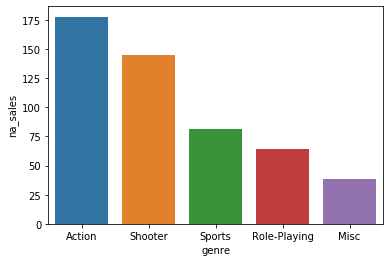

In [90]:
# отразим на графике продажи в Северной Америке

na_g = df_new.groupby('genre', as_index=False).agg({'na_sales': 'sum'}).sort_values(by ='na_sales', ascending=False).head()

ax = sns.barplot(x="genre", y="na_sales", data=na_g)

In [48]:
df_new.groupby('genre', as_index=False).agg({'eu_sales': 'sum'}).sort_values(by ='eu_sales', ascending=False).head()

,genre,eu_sales
0,Action,159.34
8,Shooter,113.47
10,Sports,69.09
7,Role-Playing,48.53
6,Racing,27.29


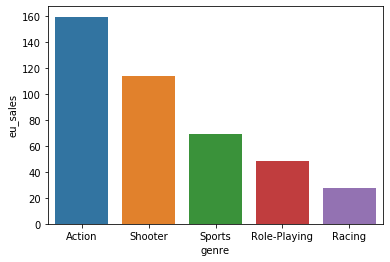

In [91]:
# отразим на графике продажи в Европе

eu_g = df_new.groupby('genre', as_index=False).agg({'eu_sales': 'sum'}).sort_values(by ='eu_sales', ascending=False).head()
ax = sns.barplot(x="genre", y="eu_sales", data=eu_g)

In [49]:
df_new.groupby('genre', as_index=False).agg({'jp_sales': 'sum'}).sort_values(by ='jp_sales', ascending=False).head()

,genre,jp_sales
7,Role-Playing,65.44
0,Action,52.80
3,Misc,12.86
9,Simulation,10.41
2,Fighting,9.44


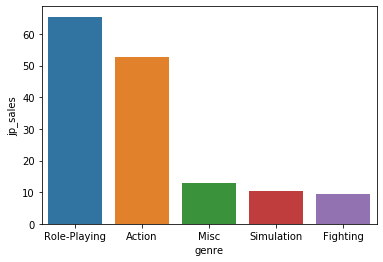

In [92]:
# отразим на графике продажи в Европе

jp_g = df_new.groupby('genre', as_index=False).agg({'jp_sales': 'sum'}).sort_values(by ='jp_sales', ascending=False).head()
ax = sns.barplot(x="genre", y="jp_sales", data=jp_g)

In [50]:
df_new.groupby('genre', as_index=False).agg({'other_sales': 'sum'}).sort_values(by ='other_sales', ascending=False).head()

,genre,other_sales
0,Action,51.14
8,Shooter,37.26
10,Sports,22.44
7,Role-Playing,14.83
3,Misc,7.67


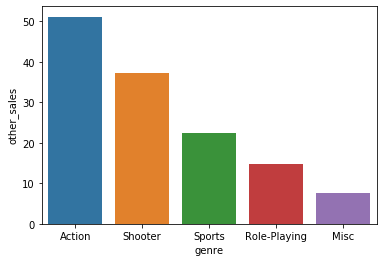

In [93]:
# отразим на графике продажи в других странах
other_g = df_new.groupby('genre', as_index=False).agg({'other_sales': 'sum'}).sort_values(by ='other_sales', ascending=False).head()
ax = sns.barplot(x="genre", y="other_sales", data=other_g)

Топ-5 самых популярных жанров меняется в зависимости от региона. Здесь похожая ситуация с платформами. В Северной Америке И Европе, а также в остальном мире предпочитают Action и Shooter игры, а в Японии - Role-Playing и Action игры. Думаю, что причина кроется в любви к аниме в Японии. 

Проверим, есть ли зависимость продаж от рейтинга ESRB

In [51]:
df_new.groupby('rating', as_index=False).agg({'na_sales': 'sum'}).sort_values(by ='na_sales', ascending=False).head()

,rating,na_sales
3,M,231.57
1,E,114.37
0,0,103.31
2,E10+,75.70
4,T,66.02


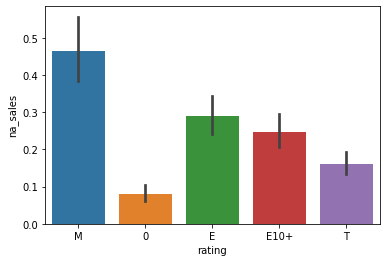

In [94]:
ax = sns.barplot(x="rating", y="na_sales", data=df_new)


In [52]:
df_new.groupby('rating', as_index=False).agg({'eu_sales': 'sum'}).sort_values(by ='eu_sales', ascending=False).head()

,rating,eu_sales
3,M,193.96
1,E,113.03
0,0,91.50
2,E10+,55.37
4,T,52.96


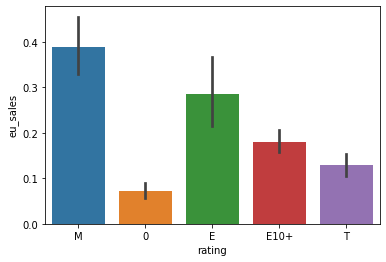

In [95]:
ax = sns.barplot(x="rating", y="eu_sales", data=df_new)

In [53]:
df_new.groupby('rating', as_index=False).agg({'jp_sales': 'sum'}).sort_values(by ='jp_sales', ascending=False).head()

,rating,jp_sales
0,0,108.84
1,E,28.33
4,T,26.02
3,M,21.20
2,E10+,8.19


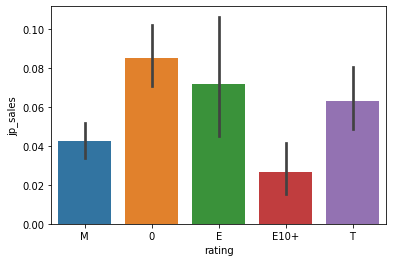

In [96]:
ax = sns.barplot(x="rating", y="jp_sales", data=df_new)

In [54]:
df_new.groupby('rating', as_index=False).agg({'other_sales': 'sum'}).sort_values(by ='other_sales', ascending=False).head()

,rating,other_sales
3,M,63.38
1,E,31.44
0,0,27.17
4,T,17.94
2,E10+,16.23


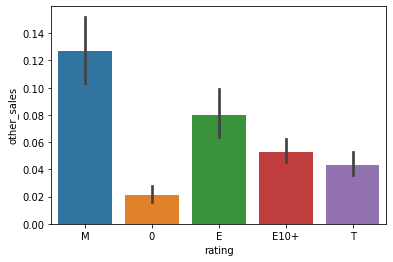

In [97]:
ax = sns.barplot(x="rating", y="other_sales", data=df_new)

Зависимость рейтинга ESRB на продажи подтверждает два предыдущих вывода. Есть виды игр, которые пользуются огромной любовью в Японии (без рейтинга, похоже, что это игры жанра Role-Playing), а есть игры, которые любят весь остальной мир - M и E (похоже, что это Shooter и Action-игры) 
Возможо, ESRB не проставляет рейтинг японским играм, потому что японская культура существует в параллельной реальности и на параллельном рынке со своими законами.И в Японии есть собственный рейтинг игр - CERO

## Исследование статистических показателей

Проверим как изменяется пользовательский рейтинг и рейтинг критиков в топ-4 жанрах (Action,Sports, Shooter, Role-Playing)

Text(0, 0.5, 'count')

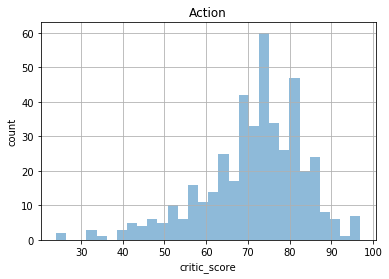

In [99]:
# построим гистограмму по жанру action для critic_score
action = df_new.query('(genre == "Action")&(critic_score != 0.00)').critic_score


df_new.query('(genre == "Action")&(critic_score != 0.00)').hist(column='critic_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Action")
plt.xlabel("critic_score")
plt.ylabel("count")

Text(0, 0.5, 'count')

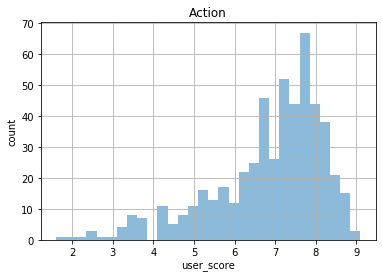

In [102]:
# построим гистограмму по жанру action для user_score
action1 = df_new.query('(genre == "Action")&(user_score != 0.00)').user_score

df_new.query('(genre == "Action")&(user_score != 0.00)').hist(column='user_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Action")
plt.xlabel("user_score")
plt.ylabel("count")


Гистограммы скошенны влево, что подтверждает, что медиана больше среднего. Есть выбросы возле нуля, но это из-за того, что я заменила данные, где нет информации о показателях, нулем, т.е. можем пренебречь этим выбросом

In [101]:
df_new.query('(genre == "Action")&(user_score != 0.00)&(critic_score != 0.00)').groupby('genre', as_index=False).agg({"critic_score": 'mean',"user_score": 'mean'})

,genre,critic_score,user_score
0,Action,71.502315,6.899306


In [103]:
# дисперсия по жанру action для critic_score
variance = np.var(action, ddof=1)
variance

146.25875250448166

In [104]:
# стандартное отклонение по жанру action для critic_score
standard_deviation = np.std(action, ddof=1)
standard_deviation

12.093748488557287

In [105]:
# дисперсия по жанру action для user_score
variance = np.var(action1, ddof=1)
variance

1.8890840494348116

In [106]:
# стандартное отклонение по жанру action для user_score
standard_deviation = np.std(action1, ddof=1)
standard_deviation

1.3744395401161928

In [107]:
df_new.query('(genre == "Shooter")&(user_score != 0.00)&(critic_score != 0.00)').groupby('genre', as_index=False).agg({"critic_score": 'mean',"user_score": 'mean'})


,genre,critic_score,user_score
0,Shooter,73.479532,6.464912


Text(0, 0.5, 'count')

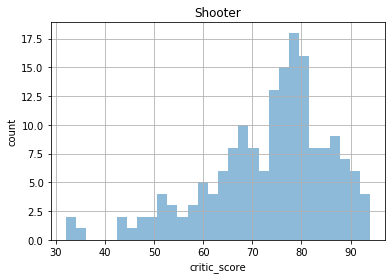

In [108]:
# построим гистограмму по жанру Shooter для critic_score
shooter = df_new.query('(genre == "Shooter")&(critic_score != 0.00)').critic_score

df_new.query('(genre == "Shooter")&(critic_score != 0.00)').hist(column='critic_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Shooter")
plt.xlabel("critic_score")
plt.ylabel("count")

Text(0, 0.5, 'count')

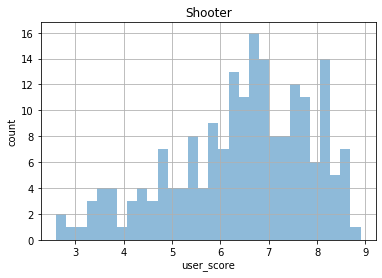

In [109]:
# построим гистограмму по жанру Shooter для user_score
shooter1 = df_new.query('(genre == "Shooter")&(user_score != 0.00)').user_score

df_new.query('(genre == "Shooter")&(user_score != 0.00)').hist(column='user_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Shooter")
plt.xlabel("user_score")
plt.ylabel("count")


In [110]:
# дисперсия по жанру shooter для critic_score
variance = np.var(shooter, ddof=1)
variance

154.88486355692967

In [111]:
# стандартное отклонение по жанру shooter для critic_score
standard_deviation = np.std(shooter, ddof=1)
standard_deviation

12.445274748149583

In [112]:
# дисперсия по жанру shooter для user_score
variance = np.var(shooter1, ddof=1)
variance

2.0655088554057612

In [113]:
# стандартное отклонение по жанру shooter для user_score
standard_deviation = np.std(shooter1, ddof=1)
standard_deviation

1.437187828853891

Text(0, 0.5, 'count')

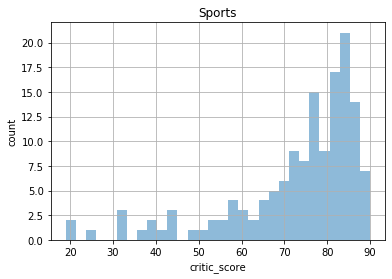

In [114]:
# построим гистограмму по жанру Sports для critic_score
sports = df_new.query('(genre == "Sports")&(critic_score != 0.00)').critic_score

df_new.query('(genre == "Sports")&(critic_score != 0.00)').hist(column='critic_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Sports")
plt.xlabel("critic_score")
plt.ylabel("count")

Text(0, 0.5, 'count')

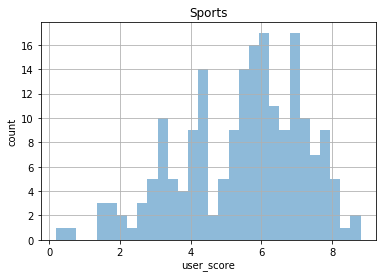

In [115]:
# построим гистограмму по жанру Sports для user_score
sports1 = df_new.query('(genre == "Sports")&(user_score != 0.00)').user_score

df_new.query('(genre == "Sports")&(user_score != 0.00)').hist(column='user_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Sports")
plt.xlabel("user_score")
plt.ylabel("count")

In [116]:
df_new.query('(genre == "Sports")&(user_score != 0.00)&(critic_score != 0.00)').groupby('genre', as_index=False).agg({"critic_score": 'mean',"user_score": 'mean'})

,genre,critic_score,user_score
0,Sports,73.340426,5.819858


In [117]:
# дисперсия по жанру Sports для critic_score
variance = np.var(sports, ddof=1)
variance

239.41849699596168

In [118]:
# стандартное отклонение по жанру Sports для critic_score
standard_deviation = np.std(sports, ddof=1)
standard_deviation

15.473154073942444

In [119]:
# дисперсия по жанру Sports для user_score
variance = np.var(sports1, ddof=1)
variance

3.022890298704733

In [120]:
# стандартное отклонение по жанру Sports для user_score
standard_deviation = np.std(sports1, ddof=1)
standard_deviation

1.738646110830129

In [121]:
# дисперсия по жанру Sports для user_score
variance = np.var(sports, ddof=1)
variance

239.41849699596168

Text(0, 0.5, 'count')

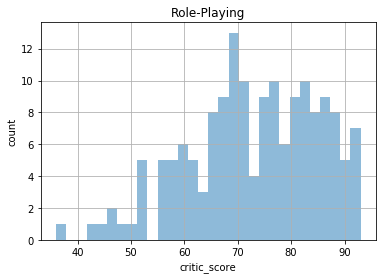

In [122]:
# построим гистограмму по жанру Role-Playing для critic_score
role = df_new.query('(genre == "Role-Playing")&(critic_score != 0.00)').critic_score
df_new.query('(genre == "Role-Playing")&(critic_score != 0.00)').hist(column='critic_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Role-Playing")
plt.xlabel("critic_score")
plt.ylabel("count")

Text(0, 0.5, 'count')

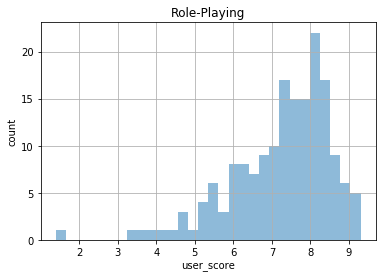

In [123]:
# построим гистограмму по жанру Role-Playing для user_score
role1 = df_new.query('(genre == "Role-Playing")&(user_score != 0.00)').user_score
df_new.query('(genre == "Role-Playing")&(user_score != 0.00)').hist(column='user_score', bins=30, alpha=0.5, sharex=True, sharey=True)
plt.title("Role-Playing")
plt.xlabel("user_score")
plt.ylabel("count")

In [124]:
df_new.query('(genre == "Role-Playing")&(user_score != 0.00)&(critic_score != 0.00)').groupby('genre', as_index=False).agg({"critic_score": 'mean',"user_score": 'mean',})

,genre,critic_score,user_score
0,Role-Playing,73.049689,7.247205


In [125]:
# дисперсия по жанру Role-Playing для critic_score
variance = np.var(role, ddof=1)
variance

150.86001552795034

In [126]:
# стандартное отклонение по жанру Role-Playing для critic_score
standard_deviation = np.std(role, ddof=1)
standard_deviation

12.282508519351833

In [127]:
# дисперсия по жанру Role-Playing для user_score
variance = np.var(role1, ddof=1)
variance

1.634912968696251

In [128]:
# стандартное отклонение по жанру Role-Playing для user_score
standard_deviation = np.std(role1, ddof=1)
standard_deviation

1.2786371528687295

Самый высокий рейтинг от критиков (кол-во макс.оценок) у игр жанра Sports, у пользователей - Role-Playing, Action. Оценки пользователей и критиков часто различаются по играм

## Проверка гипотез

In [129]:
# найдём средний пользовательский рейтинг для заданных платформ
a2 = df_new.query('(platform == "XOne")&(user_score != 0.00)').user_score
b2 = df_new.query('(platform == "PC")&(user_score != 0.00)').user_score

Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

<p> - H0 : Средние пользовательские рейтинги платформ Xbox One и PC одинаковые, т.е. a2 = b2 </p>
<p> - H1 : Средние пользовательские рейтинги платформ Xbox One и PC разные, т.е. a2 != b2 </p>
<p> alpha = 0.05  </p>

In [130]:
print('cреднее XOne: ', pd.Series(df_new.query('(platform == "XOne")&(user_score != 0.00)').user_score).mean())
print('cреднее PC: ', pd.Series(df_new.query('(platform == "PC")&(user_score != 0.00)').user_score).mean())

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(a2, b2, equal_var = True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

cреднее XOne:  6.52142857142857
cреднее PC:  6.428640776699027
p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, средние платформ XOne и PC неодинаковы, с вероятностью в 55%. Не получилось отвергнуть нулевую гипотезу.

In [131]:
# найдём средний пользовательский рейтинг для заданных жанров

a3 = pd.Series(df_new.query('(genre == "Action")&(user_score != 0.00)').user_score)
b3 = pd.Series(df_new.query('(genre == "Sports")&(user_score != 0.00)').user_score)

Проверка гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам

<p> - H0 : Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») одинаковые, т.е. a3 = b3 </p>
<p> - H1 : Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные, т.е. a3 != b3 </p>
<p> alpha = 0.05  </p>

In [132]:
print('cреднее XOne: ', pd.Series(df_new.query('(genre == "Action")&(user_score != 0.00)').user_score).mean())
print('cреднее PC: ', pd.Series(df_new.query('(genre == "Sports")&(user_score != 0.00)').user_score).mean())

alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(a3, b3, equal_var = True)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

cреднее XOne:  6.825047801147237
cреднее PC:  5.455897435897437
p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Полученное значение p-value говорит о том, что согласно нашему заданному критерию статистической значимости, средние жанров Action и Sports неодинаковы. Следовательно, можно отвергнуть нулевую гипотезу.

## Общий вывод

- Анализ показал, что изначальных данных были пропуски по столбцам "name","year_of_release", "genre", "critic_score", "user_score","rating". Причина пропусков связана с тем, что до 94-ого года не было рейтинга ESRB, также, возможно, данные просто ошибочно не были введены
- Так как до 94-ого года у нас были не все данные, а количество игр до этого периода выпускалось не так много, думаю, что для анализа данные до 94 года можно не использовать
- За анализированный период большего всего продаж было на платформах PS2 - 1233.56, X360 - 961.24, PS3 - 931.34, Wii - 891.18, DS -802.76
- Игровые предпочтения по жанрам и платформам схожи в Северной Америке, Европе и других странах, но отличаются с Японией: первые выбирают - жанры  Action и Shooter-игры на платформах PlayStation и Xbox, а вторые - жанры Role-Playing и Action-игры на платформах Nintendo и PlayStation. 
- Самый высокий рейтинг от критиков (кол-во макс.оценок) у игр жанра Sports, у пользователей - Role-Playing, Action. Оценки пользователей и критиков часто различаются по играм 
- По рейтингу ESRB нет информации по жанру Role-Playing, который так любим в Японии, а есть игры, которые любят весь остальной мир - M и E (похоже, что это Shooter и Action-игры) 
- Средние пользовательские рейтинги жанров Action (англ. «действие») и Sports (англ. «виды спорта») разные
- Средняя продолжительность активности игры 8-10 лет
- Игры платформ PlayStation самые востребованные у пользователей. С каждым новым поколением игр эта платформы продаётся всё лучше и лучше. Это заметно с релизом новых версий этой платформы.
- Я рекомендую спланировать рекламные кампании на 2017 год по платформе PlayStation (возможно, нового поколения) для всего мира, а отдельно для Японии можно добавить ещё по платформе Nintendo.